# Variational AutoEncoder

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/05/03<br>
**Last modified:** 2024/04/24<br>
**Description:** Convolutional Variational AutoEncoder (VAE) trained on MNIST digits.

## Setup

In [52]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["KERAS_BACKEND"] = "tensorflow"

In [53]:
import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers
import warnings
warnings.filterwarnings('ignore')

In [54]:
IMG_WIDTH  = 128
IMG_HEIGHT = 128

## Create a sampling layer

In [55]:
# Clear all previously registered custom objects
keras.saving.get_custom_objects().clear()
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def get_config(self):
        config = super().get_config()
        return config

## Build the encoder

In [56]:
latent_dim = 1024
def build_encoder():
    encoder_inputs = keras.Input(shape=(128, 128, 3))
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(encoder_inputs)
    x = layers.Conv2D(64, (5, 5), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(32, (5, 5), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(latent_dim, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

encoder = build_encoder()
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 64, 64,    │      3,584 │ input_layer_16[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 32, 32,    │    204,864 │ conv2d_40[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 16, 16,    │     51,232 │ conv2d_41[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 8, 8, 16)  │      4,624 │ conv2d_42[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 1024)      │          0 │ conv2d_43[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 1024)      │  1,049,600 │ flatten_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 1024)      │  1,049,600 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 1024)      │  1,049,600 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_8          │ (None, 1024)      │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,413,104 (13.02 MB)

 Trainable params: 3,413,104 (13.02 MB)

 Non-trainable params: 0 (0.00 B)

## Build the decoder

In [57]:
def build_decoder():
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(8 * 8 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((8, 8, 64))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same', strides=2)(x)
    decoder_outputs = layers.Conv2DTranspose(3, (3,3), activation="relu", padding="same", strides=2)(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    return decoder

decoder = build_decoder()
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4096)           │     4,198,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_8 (Reshape)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_40             │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_41             │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_42             │ (None, 32, 32, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_43             │ (None, 64, 64, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_44             │ (None, 128, 128, 3)    │           435 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,277,347 (16.32 MB)

 Trainable params: 4,277,347 (16.32 MB)

 Non-trainable params: 0 (0.00 B)

## Define the VAE as a `Model` with a custom `train_step`

In [58]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


## Train the VAE

In [59]:
# Task 1: Import images with labels and print in a tabular format
data_folder = "/home/dhawi/Documents/dataset"
dataset = data_folder + "/AI_project"
model_folder = "/home/dhawi/Documents/model"
history_folder = "/home/dhawi/Documents/History"

In [60]:
from tqdm import tqdm
import cv2
def load_images_from_folder(folder, subfolder):
    images = []
    gray = []
    # lab = []
    foldername = os.path.join(folder, subfolder)
    for sub in os.listdir(foldername):
        subfoldername = os.path.join(foldername, sub)
        for filename in tqdm(os.listdir(subfoldername)):
            img = cv2.imread(os.path.join(subfoldername, filename))
            img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
        # convert the image to RGB (images are read in BGR in OpenCV)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            gry = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            if img is not None:
                images.append(img/255.0)
                gray.append(gry)
                # lab.append(label)
    return np.array(images), np.array(gray)

In [61]:
caries, caries_gray = load_images_from_folder(dataset, "Caries")
gingivitis, gingivitis_gray = load_images_from_folder(dataset, "Gingivitis")
wsl, wsl_gray = load_images_from_folder(dataset, "White Spot Lesion")

100%|██████████| 2/2 [00:00<00:00,  7.97it/s]


In [62]:
def train_vae(images):
    encoder = build_encoder()
    decoder = build_decoder()
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam())
    history = vae.fit(images, epochs=150, batch_size=48)
    return history, vae

In [63]:
def save_vae(model_name, vae):
    encoder_path = model_folder + "/" + model_name + "_encoder.h5"
    decoder_path = model_folder + "/" + model_name + "_decoder.h5"
    vae.encoder.save(encoder_path)
    vae.decoder.save(decoder_path)
    vae.save(model_folder + "/" + model_name + ".h5")
    print(model_name, " Model saved")

In [64]:
import matplotlib.pyplot as plt
import json


def show_history(history, model_name):
    plt.plot(history.history['loss'])
    plt.plot(history.history['reconstruction_loss'])
    plt.plot(history.history['kl_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    # plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # Get the dictionary containing each metric and the loss for each epoch
    history_dict = history.history
    # Save it under the form of a json file
    history_file = history_folder + "/" + model_name + "_history.json"
    json.dump(history_dict, open(history_file, 'w'))

In [65]:
caries_history, caries_vae = train_vae(caries)
gingivitis_history, gingivitis_vae = train_vae(gingivitis)
wsls_history, wsls_vae = train_vae(wsl)

Epoch 1/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - kl_loss: 0.9692 - loss: 65515.7383 - reconstruction_loss: 65514.7695
Epoch 2/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - kl_loss: 4.7765 - loss: 53354.3945 - reconstruction_loss: 53349.6172
Epoch 3/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - kl_loss: 9.5320 - loss: 46596.1836 - reconstruction_loss: 46586.6523
Epoch 4/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - kl_loss: 2.1370 - loss: 41705.6328 - reconstruction_loss: 41703.4961
Epoch 5/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 2.5885 - loss: 38547.0664 - reconstruction_loss: 38544.4766
Epoch 6/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - kl_loss: 5.4166 - loss: 36244.5664 - reconstruction_loss: 36239.1484
Epoch 7/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 6.8440 - loss: 34561.5391 - reconstruction_loss: 34554.6953
Epoch 8/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - kl_loss: 7.7834 - loss: 33115.1211 - reconstruction_loss: 33107.3359
Epoch 9/150
1/1 ━━━━━━━━━━━━━━━━━━

In [66]:
save_vae("fyp_caries_vae1024v2", caries_vae)
save_vae("fyp_gingivitis_vae1024v2", gingivitis_vae)
save_vae("fyp_wsls_vae1024v2", wsls_vae)

fyp_caries_vae1024  Model saved
fyp_gingivitis_vae1024  Model saved
fyp_wsls_vae1024  Model saved


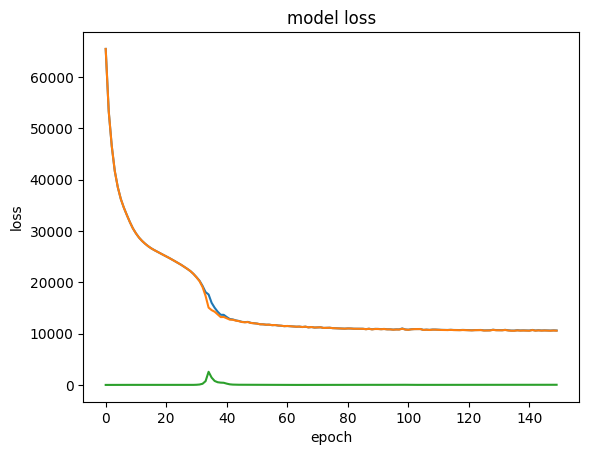

In [67]:
show_history(caries_history, "caries_vae1024v2")

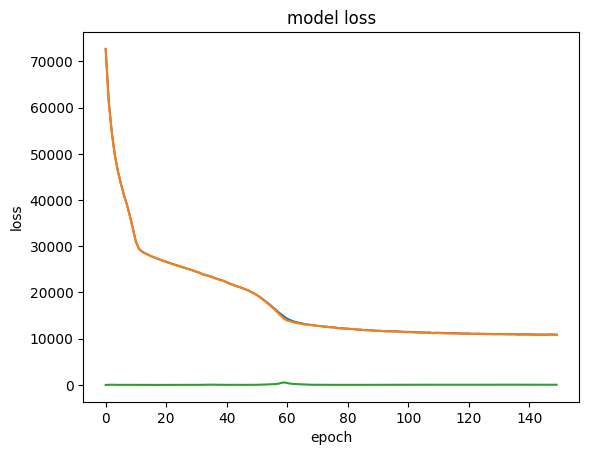

In [68]:
show_history(gingivitis_history, "noncaries_vae1024v2")

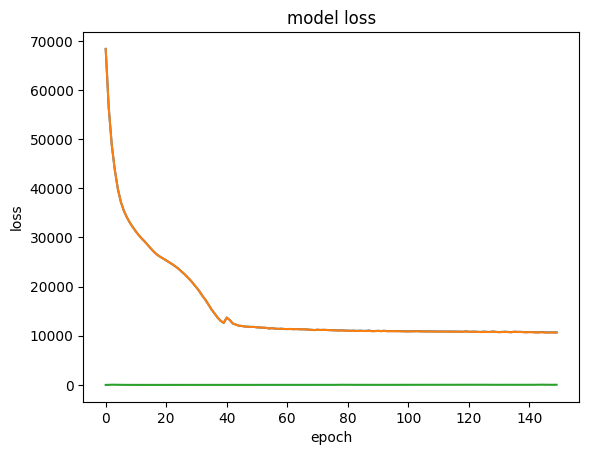

In [69]:
show_history(wsls_history, "wsls_vae1024v2")

In [70]:
def show_images(images):
    for i in range(4):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [71]:
def test_vae(images, encoder, decoder):
    predictions = encoder.predict(images)
    predictions = decoder.predict(predictions[2])
    show_images(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


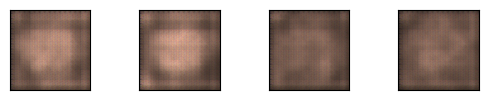

In [72]:
test_vae(caries, caries_vae.encoder, caries_vae.decoder)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


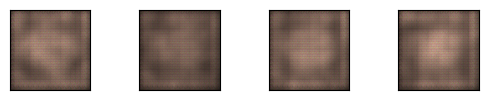

In [73]:
test_vae(gingivitis, gingivitis_vae.encoder, gingivitis_vae.decoder)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


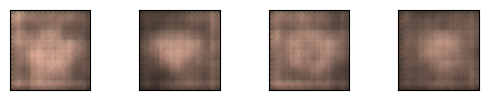

In [74]:
test_vae(wsl, wsls_vae.encoder, wsls_vae.decoder)

In [75]:
predictions = caries_vae.encoder.predict(caries)
len(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


3